# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Model training</span>

<span style="font-width:bold; font-size: 1.4rem;">In this last notebook, we will train a model on the dataset we created in the previous tutorial. We can train our model using standard Python and machine learning frameworks such as Scikit-learn, PySpark, TensorFlow, and PyTorch.</span>

## 🗒️ This notebook is divided in 3 main sections:
1. Loading the training data.
2. Model training.
3. Model's Predictions Visualization.

![tutorial-flow](images/03_model.png)

---
## <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [1]:
import hsfs

conn = hsfs.connection()

fs = conn.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.


---

## <span style="color:#ff5f27;">🪝 Feature View and Training Dataset Retrieval</span>

To retrieve training dataset from Feature Store we retrieve **Feature View** using `FeatureStore.get_feature_view()` method.

Then we can use **Feature View** in order to retrieve **training dataset** using `FeatureView.get_train_test_split()` method.

In [2]:
feature_view = fs.get_feature_view(
    name = 'electricity_feature_view',
    version = 1
)

In [3]:
X_train, y_train, X_test, y_test = feature_view.get_train_test_split(
    training_dataset_version = 2
)

In [4]:
X_train.head()

,index,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,...,rrp_positive,demand_neg_rrp,rrp_negative,demand_pos_rrp,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
0,154,1433376000000,4.4,11.3,5.5,0.0,3,4,155,23,...,33.050285,0.000,0.0,147155.265,134826.100714,15277.541585,132421.544286,12121.312927,129020.392667,11456.502219
1,573,1469577600000,7.5,12.9,6.9,0.4,2,27,209,30,...,36.397463,0.000,0.0,143209.755,133247.215000,10620.203460,132380.252857,10598.615006,132709.017833,10018.226341
2,635,1474934400000,7.4,14.8,13.4,12.6,1,27,271,39,...,49.794504,0.000,0.0,126888.770,121418.018571,10496.400154,122401.794643,10304.147294,123663.239167,9448.684467
3,654,1476576000000,17.4,23.1,8.0,0.0,6,16,290,41,...,22.474960,1740.595,-3.6,100052.440,117109.188571,12509.209925,115471.599286,11851.022854,116607.459500,10873.536035
4,872,1495411200000,10.4,20.3,10.1,0.0,0,22,142,21,...,72.931488,0.000,0.0,113551.040,118247.162143,8599.465978,119668.648214,8471.561767,116976.748167,9751.151336


---

## <span style="color:#ff5f27;">🤖 Model Building</span>

### <span style="color:#ff5f27;">📝 Imports</span>

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

2022-07-26 13:12:53,329 INFO: generated new fontManager


### <span style="color:#ff5f27;">🧑🏻‍🔬 RandomForestRegressor</span>

In [6]:
reg = RandomForestRegressor(
    n_estimators = 25,
    max_features = 'sqrt',
    n_jobs = -1,
    random_state = 42
)

reg.fit(X_train.drop(['index','date'], axis = 1),y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=25, n_jobs=-1,
                      random_state=42)

In [7]:
preds = reg.predict(X_test.drop(['index','date'],axis = 1))

r2_score(y_test, preds)

0.9704849789512962

---

## <span style="color:#ff5f27;">🔬 🧬 Model Predictions Visualization</span>

In [8]:
X_test['preds'] = preds
X_train['target'] = y_train
X_train.date = pd.to_datetime(X_train.date)
X_test.date = pd.to_datetime(X_test.date)

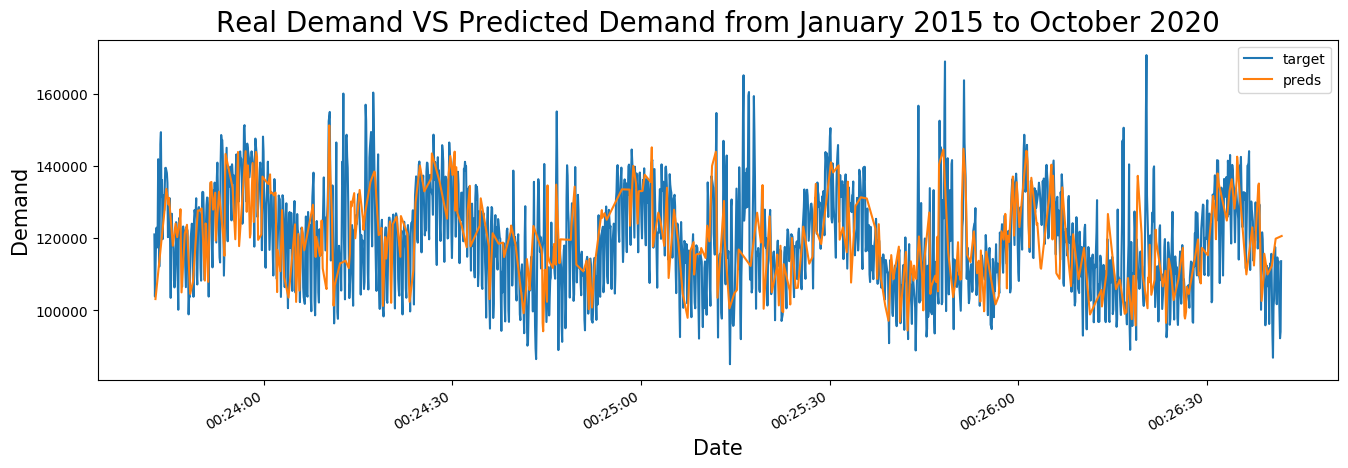

In [9]:
fig,ax = plt.subplots(figsize = (16,5))

X_train.plot('date','target', ax = ax)
X_test.plot('date','preds', ax = ax)

ax.set_xlabel('Date',fontsize = 15)
ax.set_ylabel('Demand',fontsize = 15)
ax.set_title('Real Demand VS Predicted Demand from January 2015 to October 2020',fontsize = 20)

plt.show()

---
## <span style='color:#ff5f27'>👮🏼‍♀️ Model Registry</span>

In [10]:
import hsml

conn = hsml.connection()
mr = conn.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [13]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train.drop(['index','date','target'],axis = 1))
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'min_temperature',
    'type': 'float64'},
   {'name': 'max_temperature', 'type': 'float64'},
   {'name': 'solar_exposure', 'type': 'float64'},
   {'name': 'rainfall', 'type': 'float64'},
   {'name': 'day_of_week', 'type': 'int64'},
   {'name': 'day_of_month', 'type': 'int64'},
   {'name': 'day_of_year', 'type': 'int64'},
   {'name': 'week_of_year', 'type': 'int64'},
   {'name': 'month', 'type': 'int64'},
   {'name': 'quarter', 'type': 'int64'},
   {'name': 'year', 'type': 'int64'},
   {'name': 'school_day', 'type': 'int64'},
   {'name': 'holiday', 'type': 'int64'},
   {'name': 'rrp', 'type': 'float64'},
   {'name': 'frac_at_neg_rrp', 'type': 'float64'},
   {'name': 'rrp_positive', 'type': 'float64'},
   {'name': 'demand_neg_rrp', 'type': 'float64'},
   {'name': 'rrp_negative', 'type': 'float64'},
   {'name': 'demand_pos_rrp', 'type': 'float64'},
   {'name': 'demand_7_mean', 'type': 'float64'},
   {'name': 'demand_7_std', 'type': 'float64'

In [14]:
import joblib

pkl_file_name = "forest.pkl"

joblib.dump(reg, pkl_file_name)

model = mr.sklearn.create_model(
    name = "forestmodel",
    input_example = X_train.drop(['index','date','target'],axis = 1).sample(),
    model_schema = model_schema
)

model.save(pkl_file_name)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://0f060790-06a4-11ed-8aed-d1422d4ec537.cloud.hopsworks.ai/p/2168/models/forestmodel/1


Model(name: 'forestmodel', version: 1)

---

## <span style='color:#ff5f27'>🚀 Model Retrieving</span>

In [15]:
model = mr.get_model("forestmodel", version = 1)

model_dir = model.download()
model = joblib.load(model_dir + "/forest.pkl")

---
## <span style='color:#ff5f27'>🔮 Predicting</span>

In [17]:
batch = feature_view.get_batch_data().drop('index', axis = 1)
batch.sort_values('date',inplace = True)
batch.head()

2022-07-26 13:16:14,370 INFO: USE `electricity_demand_featurestore`
2022-07-26 13:16:15,082 INFO: WITH right_fg0 AS (SELECT *
FROM (SELECT `fg2`.`index` `index`, `fg2`.`date` `date`, `fg2`.`min_temperature` `min_temperature`, `fg2`.`max_temperature` `max_temperature`, `fg2`.`solar_exposure` `solar_exposure`, `fg2`.`rainfall` `rainfall`, `fg2`.`day_of_week` `day_of_week`, `fg2`.`day_of_month` `day_of_month`, `fg2`.`day_of_year` `day_of_year`, `fg2`.`week_of_year` `week_of_year`, `fg2`.`month` `month`, `fg2`.`quarter` `quarter`, `fg2`.`year` `year`, `fg2`.`index` `join_pk_index`, `fg2`.`date` `join_evt_date`, `fg0`.`school_day` `school_day`, `fg0`.`holiday` `holiday`, RANK() OVER (PARTITION BY `fg2`.`index`, `fg2`.`date`, `fg2`.`date` ORDER BY `fg0`.`date` DESC) pit_rank_hopsworks
FROM `electricity_demand_featurestore`.`weather_fg_1` `fg2`
INNER JOIN `electricity_demand_featurestore`.`calendar_fg_1` `fg0` ON `fg2`.`index` = `fg0`.`index` AND `fg2`.`date` = `fg0`.`date` AND `fg2`.`date` >

,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,month,...,rrp_positive,demand_neg_rrp,rrp_negative,demand_pos_rrp,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
1418,1422576000000,13.1,21.0,27.6,0.0,4,30,30,5,1,...,21.029356,0.0,0.0,121018.15,113361.206429,8840.007476,119750.684643,17637.057172,121135.323333,16463.479261
1419,1422662400000,14.3,20.2,26.2,0.0,5,31,31,5,1,...,16.538847,0.0,0.0,103822.97,111577.260714,9388.612319,120068.660357,17277.849041,121274.921333,16291.746026
1661,1422748800000,13.2,19.0,17.3,9.2,6,1,32,5,2,...,14.578844,0.0,0.0,100178.84,111894.315000,8875.547703,120243.666786,17045.002549,120294.015667,16654.688684
1420,1422835200000,13.5,21.1,23.9,3.8,0,2,33,6,2,...,22.270032,0.0,0.0,118694.16,114026.412143,8377.113294,120373.024643,17024.396712,119507.136333,16128.447829
0,1422921600000,16.1,20.0,22.7,0.0,1,3,34,6,2,...,27.003832,0.0,0.0,122880.13,114667.386429,8920.937447,119938.167857,16864.969397,120125.450167,15880.221937


In [19]:
model.predict(batch.drop('date', axis = 1).iloc[:50])

array([121023.6862, 104064.8366, 103121.665 , 118103.89  , 123047.3766,
       117826.6184, 122216.4932, 135280.1226, 127887.1672, 110606.7868,
       128534.1014, 143431.2028, 146782.145 , 133111.269 , 134158.2942,
       118756.8796, 124023.7372, 131462.5314, 127889.0688, 128117.5314,
       139081.4466, 138395.6372, 133621.7406, 135994.292 , 133626.17  ,
       120393.6708, 129285.8248, 131134.3308, 130296.799 , 116674.7836,
       105428.268 , 122835.8586, 126478.5848, 120758.5824, 117879.5792,
       117769.9842, 107544.9126, 106098.3768, 107046.6752, 124025.7896,
       124251.8676, 121719.3452, 120270.1148, 108976.008 , 101234.4234,
       123872.2652, 125040.5692, 125283.1574, 127996.6382, 119679.9242])

---